### Bollinger Bands

The only mean-reversal strategy I have described so far is the linear strategy: simply scale the number of units invested in a stationary unit portfolio to be proportional to the deviation of the market value (price) of the unit portfolio from a moving average.This simple strategy is chosen because it is virtually parameterless, and therefore least subject to data-snooping bias. While this linear strategy is useful for demonstrating whether mean reversion trading can be profitable for a given portfolio, it is not practical because we don’t know beforehand what the maximum capital deployed will be, as there is no limit to the temporary deviation of the price from its average.

For practical trading, we can use the Bollinger band, where we enter into a position only when the price deviates by more than *entryZscore* standard deviations from the mean. *entryZscore* is a free parameter to be optimized in a training set, and both standard deviation and mean are computed within a look-back period, whose length again can be a free parameter to be optimized, or it can be set equal to the half-life of mean reversion. We can exit when the price mean-reverts to *exitZscore* standard deviations from the mean, where *exitZscore* < *entryZscore*. Note that if *exitZscore* = 0, this means we will exit when the price mean-reverts to the current mean. If *exitZscore* = −*entryZscore*, we will exit when the price moves beyond the opposite band so as to trigger a trading signal of the opposite sign. At any one time, we can have either zero or one unit (long or short) invested, so it is very easy to allocate capital to this strategy or to manage its risk. If we set the look-back to a short period, and small *entryZscore* and *exitZscore* magnitude, we will get a shorter holding period and more round trip trades and generally higher
profits. We illustrate the Bollinger band technique in Example 3.2 using the pair GLD-USO we discussed above.

### Example 3.2: Bollinger Band Mean Reversion Strategy

We traded GLD-USO in Example 3.1 using price spread USO- hedgeRatio\*GLD as the signal with a linear mean reversion strategy. Here, we simply switch to a Bollinger band strategy, using the
entryZscore = 1 and exitZscore = 0, with the first part of the program identical to PriceSpread.py.The present source code is in bollinger.py. Notice that the entry signals longsEntry and shortsEntry are Tx1 logical arrays, as are the exit signals longsExit and shortsExit. We initialize the number of units of the unit portfolio on the long side, numUnitsLong, a Tx1 array, and then set one of its values to 1 if we have a long entry signal, and to 0 if we have a long exit signal; and vice versa for the number of units on the short side. For those days that do not have any entry or exit signals, we use the *fillna* function with **ffill** method to carry forward the previous day’s units. (**ffill** starts with the second row of an array, and overwrites any cell’s NaN value with the corresponding cell’s value in the previous row. It can be downloaded from my website.) Once numUnitsLong and numUnitsShort are computed, we can combine them to find the net number of units denoted by numUnits.The rest of the program is the same as in Example 3.1’s PriceSpread.py.

<Axes: xlabel='May 24, 2006, to April 9, 2012', ylabel='Share price $'>

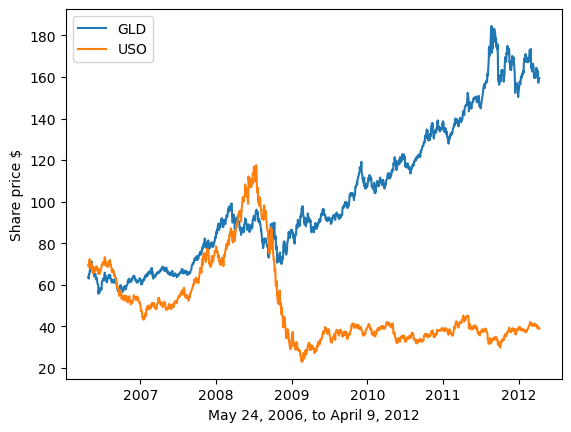

In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('inputData_GLD_USO.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

df.plot(xlabel='May 24, 2006, to April 9, 2012', ylabel='Share price $')

<Axes: xlabel='May 24, 2006, to April 9, 2012', ylabel='spread=USO-hedgeRatio*GLD'>

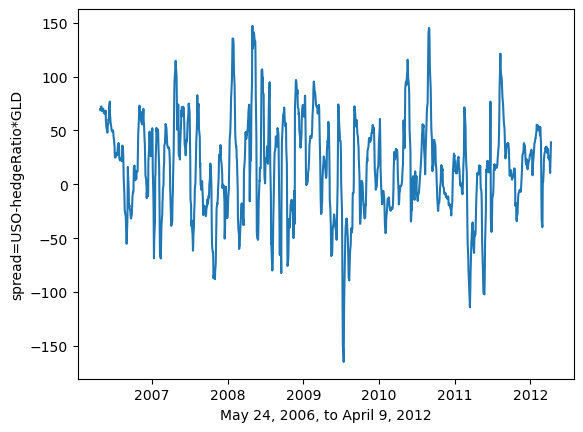

In [2]:
# Bollinger Band Mean Reversion Strategy
lookback=20
hedgeRatio=np.full(df.shape[0], np.nan)
for t in np.arange(lookback, len(hedgeRatio)):
    # Note this can deal with NaN in top row
    regress_results=sm.ols(formula="USO ~ GLD", data=df[(t-lookback):t]).fit()
    hedgeRatio[t-1]=regress_results.params[1]

yport=np.sum(ts.add_constant(-hedgeRatio)[:, [1,0]]*df, axis=1)
yport.plot(
    xlabel='May 24, 2006, to April 9, 2012',
    ylabel='spread=USO-hedgeRatio*GLD')

<Axes: xlabel='May 24, 2006, to April 9, 2012', ylabel='Cumulative Returns'>

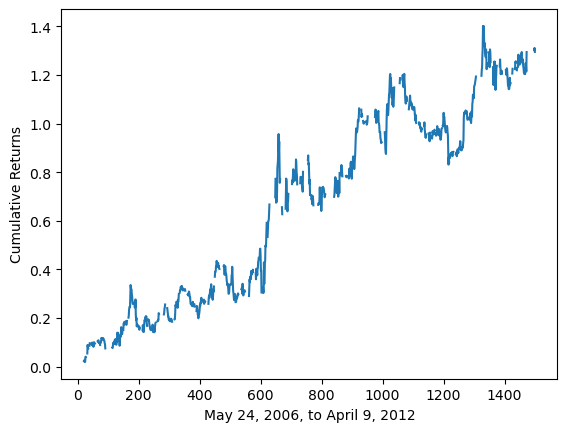

In [3]:
# Bollinger band strategy
entryZscore=1
exitZscore=0

MA=yport.rolling(lookback).mean()
MSTD=yport.rolling(lookback).std()
zScore=(yport-MA)/MSTD

longsEntry=zScore < -entryZscore
longsExit =zScore > -entryZscore

shortsEntry=zScore > entryZscore
shortsExit =zScore < exitZscore

numUnitsLong=np.zeros(longsEntry.shape)
numUnitsLong[:]=np.nan

numUnitsShort=np.zeros(shortsEntry.shape)
numUnitsShort[:]=np.nan

numUnitsLong[0]=0
numUnitsLong[longsEntry]=1
numUnitsLong[longsExit]=0
numUnitsLong=pd.DataFrame(numUnitsLong)
numUnitsLong.fillna(method='ffill', inplace=True)

numUnitsShort[0]=0
numUnitsShort[shortsEntry]=-1
numUnitsShort[shortsExit]=0
numUnitsShort=pd.DataFrame(numUnitsShort)
numUnitsShort.fillna(method='ffill', inplace=True)

numUnits=numUnitsLong+numUnitsShort
positions=pd.DataFrame(np.tile(numUnits.values, [1, 2]) * ts.add_constant(-hedgeRatio)[:, [1,0]] *df.values) #  [hedgeRatio -ones(size(hedgeRatio))] is the shares allocation, [hedgeRatio -ones(size(hedgeRatio))].*y2 is the dollar capital allocation, while positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1+ret)-1).plot(
    xlabel='May 24, 2006, to April 9, 2012',
    ylabel='Cumulative Returns',
)

**FIGURE 3.3** Cumulative Returns of Bollinger Band Strategy on GLD-USO

In [4]:
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))

APR=0.149725 Sharpe=1.110355
